# Brain Tumor Classification
# Cláudia Afonso nº 36273 & Rita Rodrigues nº 54859

### Importing Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

### Data loading

In [ ]:
path = "/content/drive/MyDrive/MCD/AAA/Project/Data"

In [ ]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

class_map = {
    'no_tumor': 0,
    'glioma_tumor': 1,
    'meningioma_tumor': 2,
    'pituitary_tumor': 3
}

In [ ]:
h, w = 80, 80

In [ ]:
IMAGE = []
LABELS = []

for label in labels:
    folderPath = os.path.join('/content/drive/MyDrive/MCD/AAA/Project/Data/Training', label)
    for j in tqdm(os.listdir(folderPath)):
        img_path = os.path.join(folderPath, j)
        try:
            img = cv2.imread(img_path)
            if img is None or img.size == 0:
                print(f"Skipping corrupted image: {img_path}")
                continue
            img = cv2.resize(img,(h, w))
            IMAGE.append(img)
            LABELS.append(class_map[label])
        except Exception as e:
            print(f"Skipping invalid image: {img_path} due to error: {e}")
            continue
            
        
for label in labels:
    folderPath = os.path.join('/content/drive/MyDrive/MCD/AAA/Project/Data/Testing', label)
    for j in tqdm(os.listdir(folderPath)):
        img_path = os.path.join(folderPath, j)
        try:
            img = cv2.imread(img_path)
            if img is None or img.size == 0:
                print(f"Skipping corrupted image: {img_path}")
                continue
            img = cv2.resize(img,(h, w))
            IMAGE.append(img)
            LABELS.append(class_map[label])
        except Exception as e:
            print(f"Skipping invalid image: {img_path} due to error: {e}")
            continue
        
X = np.array(IMAGE)
y = np.array(LABELS)

100%|██████████| 74/74 [00:00<00:00, 134.30it/s]


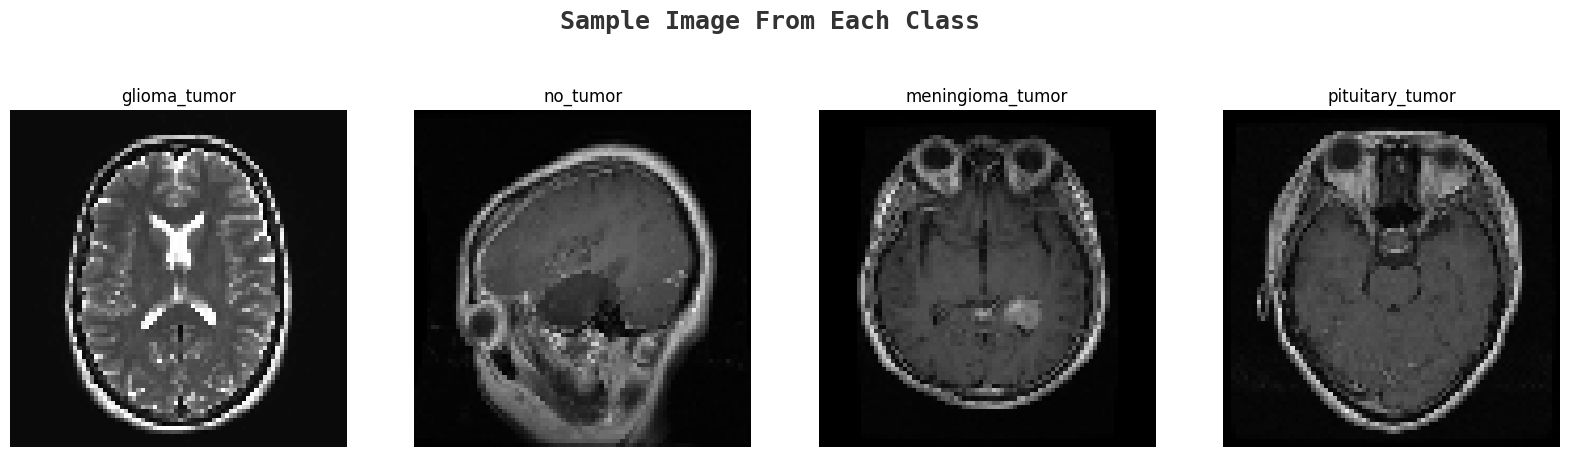

In [ ]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Class',size=18,fontweight='bold',
             fontname='monospace',y=0.62,x=0.4,alpha=0.8)
for i in [0,1,2,3]:
    j=0
    while True :
        if y[j]==i:
            ax[k].imshow(X[j])
            ax[k].set_title(labels[y[j]])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [ ]:
unique_labels, label_counts = np.unique(y, return_counts=True)

# Print the number of images in each label
for label, count in zip(unique_labels, label_counts):
    print(f"Number of images with label {label}: {count}")

Number of images with label 0: 500
Number of images with label 1: 926
Number of images with label 2: 937
Number of images with label 3: 901


## Data augmentation

In [ ]:
datagen = ImageDataGenerator(rotation_range=90, vertical_flip=True)

# Generate augmented images and their corresponding labels three times
num_augmented_images = 3
X_augmented = []
y_augmented = []

for i in range(num_augmented_images):
    # Apply data augmentation to the original images
    generator = datagen.flow(X, y, batch_size=len(X), shuffle=True)
    X_batch, y_batch = generator.next()
    
    # Append the augmented images and their labels to the output arrays
    X_augmented.append(X_batch)
    y_augmented.append(y_batch)
    
# Combine the augmented images and labels into a single array
X_augmented = np.concatenate(X_augmented)
y_augmented = np.concatenate(y_augmented)

## Data preparation

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_augmented, y_augmented, test_size=0.10, random_state=42)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8812, 80, 80, 3), (980, 80, 80, 3), (8812,), (980,))

## Boosting

In [ ]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb
import tensorflow as tf
import pandas as pd
from sklearn.metrics import accuracy_score

In [ ]:
# Reshape the data into a two-dimensional matrix
num_instances = X_train.shape[0]
height = X_train.shape[1]
width = X_train.shape[2]
num_channels = X_train.shape[3]
X_train_2d = X_train.reshape(num_instances, height*width*num_channels)

In [ ]:
X_test_2d = X_test.reshape(X_test.shape[0], height*width*num_channels)

#### Adaboost

In [ ]:
ada = AdaBoostClassifier(n_estimators=3)
ada.fit(X_train_2d, y_train)

AdaBoostClassifier(n_estimators=3)

#### Gradient Boosting

In [ ]:
gb = GradientBoostingClassifier(n_estimators=3)
gb.fit(X_train_2d, y_train)

#### XGBoost

In [ ]:
xgb_model = xgb.XGBClassifier(n_estimators=3, learning_rate=0.1, max_depth=5)
xgb_model.fit(X_train_2d, y_train)

### Save models

In [ ]:
import pickle

In [ ]:
# Save the models to disk
with open('/content/drive/MyDrive/MCD/AAA/Project/Models/adaboost_model.pkl', 'wb') as f:
    pickle.dump(ada, f)

with open('/content/drive/MyDrive/MCD/AAA/Project/Models/gradient_boosting_model.pkl', 'wb') as f:
    pickle.dump(gb, f)

with open('/content/drive/MyDrive/MCD/AAA/Project/Models/xgboost_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)

## Convolutional XGBoost

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D,Dense,MaxPool2D,Flatten,Dropout,BatchNormalization

In [ ]:
model1 = keras.Sequential()
model1.add(Conv2D(64, (2,2), activation="relu"))
model1.add(BatchNormalization())
model1.add(Conv2D(64, (2,2), activation="relu"))
model1.add(BatchNormalization())
model1.add(MaxPool2D(pool_size=(2,2)))
model1.add(Dropout(0.1))
model1.add(Conv2D(32, (2,2), activation="relu"))
model1.add(BatchNormalization())
model1.add(Conv2D(32, (2,2), activation="relu"))
model1.add(BatchNormalization())
model1.add(MaxPool2D(pool_size=(2,2)))
model1.add(Dropout(0.1))
model1.add(Conv2D(16, (2,2), activation="relu"))
model1.add(BatchNormalization())
model1.add(Conv2D(16, (2,2), activation="relu"))
model1.add(BatchNormalization())
model1.add(MaxPool2D(pool_size=(2,2)))
model1.add(Dropout(0.1))
model1.add(Conv2D(8, (2,2), activation="relu"))
model1.add(BatchNormalization())
model1.add(Conv2D(8, (2,2), activation="relu"))
model1.add(BatchNormalization())
model1.add(MaxPool2D(pool_size=(2,2)))
model1.add(Dropout(0.1))
model1.add(Flatten())
model1.add(Dense(1024, activation="softmax", name = "my_dense"))
model1.add(Dropout(0.2))
model1.add(Dense(4, activation="softmax"))

In [ ]:
opt = keras.optimizers.Adam(learning_rate = 0.001)

In [ ]:
model1.compile(optimizer = opt, loss='categorical_crossentropy', metrics=["accuracy"])

In [ ]:
X_train = tf.cast(X_train, tf.float32)

In [ ]:
X_test = tf.cast(X_test, tf.float32)

In [ ]:
import pandas as pd
y_train = np.array(pd.get_dummies(y_train))

In [ ]:
y_test = np.array(pd.get_dummies(y_test))

In [ ]:
history = model1.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 16, epochs = 100)

Epoch 1/100
551/551 [==============================] - 23s 23ms/step - loss: 1.2522 - accuracy: 0.4452 - val_loss: 1.2825 - val_accuracy: 0.3837
Epoch 2/100
551/551 [==============================] - 12s 21ms/step - loss: 1.1105 - accuracy: 0.4936 - val_loss: 1.0302 - val_accuracy: 0.5510
Epoch 3/100
551/551 [==============================] - 12s 21ms/step - loss: 1.0431 - accuracy: 0.5267 - val_loss: 1.0437 - val_accuracy: 0.5571
Epoch 4/100
551/551 [==============================] - 12s 21ms/step - loss: 0.9912 - accuracy: 0.5630 - val_loss: 0.9140 - val_accuracy: 0.5918
Epoch 5/100
551/551 [==============================] - 12s 21ms/step - loss: 0.9476 - accuracy: 0.5843 - val_loss: 0.8498 - val_accuracy: 0.6837
Epoch 6/100
551/551 [==============================] - 12s 21ms/step - loss: 0.9037 - accuracy: 0.6152 - val_loss: 0.8029 - val_accuracy: 0.7051
Epoch 7/100
551/551 [==============================] - 12s 22ms/step - loss: 0.8604 - accuracy: 0.6416 - val_loss: 1.0339 - val_ac

In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 79, 79, 64)        832       
                                                                 
 batch_normalization (BatchN  (None, 79, 79, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 78, 78, 64)        16448     
                                                                 
 batch_normalization_1 (Batc  (None, 78, 78, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 39, 39, 64)       0         
 )                                                               
                                                        

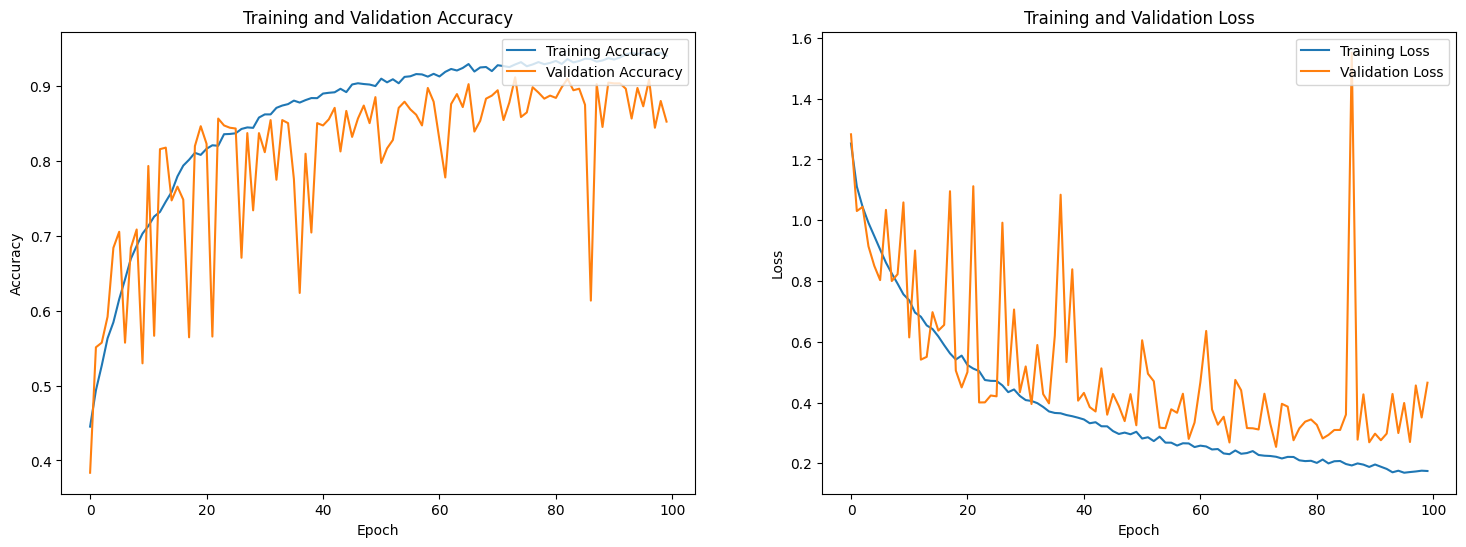

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['accuracy']))

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot(range(len(history.history['accuracy'])), acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from tensorflow.keras.models import save_model
save_model(model1, '/content/drive/MyDrive/MCD/AAA/Project/Models/cnn.h5')

In [ ]:
from keras.models import Model
new_model = tf.keras.models.Model(
    model1.input,
    model1.get_layer('my_dense').output
)
   

In [ ]:
X_train_features = new_model.predict(X_train)

276/276 [==============================] - 1s 5ms/step


In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier(objective='multiclass:softmax', learning_rate = 0.1,
              max_depth = 15, n_estimators = 500)
xgb.fit(X_train_features, np.argmax(y_train, axis = 1))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [ ]:
with open('/content/drive/MyDrive/MCD/AAA/Project/Models/xgboost_conv_model.pkl', 'wb') as f:
    pickle.dump(xgb, f)

## Auto - encoder

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D,Dense,MaxPool2D,Flatten,Dropout,BatchNormalization, InputLayer

In [ ]:
model2 = keras.Sequential()
model2.add(Conv2D(128, (2,2), activation="relu"))
model2.add(BatchNormalization())
model2.add(Conv2D(128, (2,2), activation="relu"))
model2.add(BatchNormalization())
model2.add(MaxPool2D(pool_size=(2,2)))
model2.add(Dropout(0.1))
model2.add(Conv2D(64, (2,2), activation="relu"))
model2.add(BatchNormalization())
model2.add(Conv2D(64, (2,2), activation="relu"))
model2.add(BatchNormalization())
model2.add(MaxPool2D(pool_size=(2,2)))
model2.add(Dropout(0.1))
model2.add(Conv2D(32, (2,2), activation="relu"))
model2.add(BatchNormalization())
model2.add(MaxPool2D(pool_size=(2,2)))
model2.add(Conv2D(64, (2,2), activation="relu"))
model2.add(Conv2D(64, (2,2), activation="relu"))
model2.add(BatchNormalization())
model2.add(MaxPool2D(pool_size=(2,2)))
model2.add(Dropout(0.1))
model2.add(Flatten())
model2.add(Dense(4, activation="softmax"))

In [ ]:
opt = keras.optimizers.Adam(learning_rate = 0.001)

In [ ]:
model2.compile(optimizer = opt, loss='categorical_crossentropy', metrics=["accuracy"])

In [ ]:
X_train = tf.cast(X_train, tf.float32)

In [ ]:
import pandas as pd
y_train = np.array(pd.get_dummies(y_train))

In [ ]:
model2.fit(X_train, y_train, batch_size = 16, epochs = 100)

Epoch 1/100
551/551 [==============================] - 37s 39ms/step - loss: 1.0702 - accuracy: 0.5968
Epoch 2/100
551/551 [==============================] - 21s 38ms/step - loss: 0.7170 - accuracy: 0.7165
Epoch 3/100
551/551 [==============================] - 21s 38ms/step - loss: 0.5458 - accuracy: 0.7913
Epoch 4/100
551/551 [==============================] - 21s 39ms/step - loss: 0.4527 - accuracy: 0.8249
Epoch 5/100
551/551 [==============================] - 21s 38ms/step - loss: 0.4007 - accuracy: 0.8479
Epoch 6/100
551/551 [==============================] - 21s 39ms/step - loss: 0.3387 - accuracy: 0.8748
Epoch 7/100
551/551 [==============================] - 21s 38ms/step - loss: 0.3115 - accuracy: 0.8846
Epoch 8/100
551/551 [==============================] - 21s 38ms/step - loss: 0.2744 - accuracy: 0.8981
Epoch 9/100
551/551 [==============================] - 21s 39ms/step - loss: 0.2490 - accuracy: 0.9088
Epoch 10/100
551/551 [==============================] - 21s 39ms/step - l

In [ ]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 79, 79, 128)       1664      
                                                                 
 batch_normalization (BatchN  (None, 79, 79, 128)      512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 78, 78, 128)       65664     
                                                                 
 batch_normalization_1 (Batc  (None, 78, 78, 128)      512       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 39, 39, 128)      0         
 )                                                               
                                                        

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import save_model

save_model(model2, '/content/drive/MyDrive/MCD/AAA/Project/Models/auto-encoder.h5')

## Transfer Learning

### VGG16

In [ ]:
import keras
from keras.applications.vgg16 import preprocess_input,VGG16
import tensorflow as tf
from keras.models import Sequential,Model
from keras.layers import MaxPooling2D,Conv2D,Dense,BatchNormalization,Dropout,GlobalAveragePooling2D,Flatten,Input
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from sklearn.metrics import classification_report
from keras.utils.vis_utils import plot_model
from tensorflow.keras.models import save_model

In [ ]:

# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)


In [ ]:
#with tpu_strategy.scope():
vgg_model = VGG16(weights='imagenet',include_top=False)
for layers in vgg_model.layers:
    layers.trainable=False
x=vgg_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(128,activation='relu')(x)
x=Dropout(0.15)(x)
output=Dense(4,activation='softmax')(x)
model3=Model(inputs=vgg_model.input,outputs=output)
model3.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
import pandas as pd
y_train = np.array(pd.get_dummies(y_train))

In [ ]:
r2=model3.fit(X_train, y_train, epochs=20)

Epoch 1/20
276/276 [==============================] - 59s 210ms/step - loss: 1.6972 - accuracy: 0.5808
Epoch 2/20
276/276 [==============================] - 57s 206ms/step - loss: 0.7126 - accuracy: 0.7191
Epoch 3/20
276/276 [==============================] - 59s 214ms/step - loss: 0.5545 - accuracy: 0.7821
Epoch 4/20
276/276 [==============================] - 55s 200ms/step - loss: 0.4871 - accuracy: 0.8071
Epoch 5/20
276/276 [==============================] - 56s 202ms/step - loss: 0.4107 - accuracy: 0.8392
Epoch 6/20
276/276 [==============================] - 55s 198ms/step - loss: 0.3794 - accuracy: 0.8457
Epoch 7/20
276/276 [==============================] - 56s 204ms/step - loss: 0.3375 - accuracy: 0.8697
Epoch 8/20
276/276 [==============================] - 56s 202ms/step - loss: 0.3023 - accuracy: 0.8825
Epoch 9/20
276/276 [==============================] - 57s 207ms/step - loss: 0.2739 - accuracy: 0.8921
Epoch 10/20
276/276 [==============================] - 55s 199ms/step - l

In [ ]:
save_model(model3, '/content/drive/MyDrive/MCD/AAA/Project/Models/vgg16.h5')

### ResNet-50

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [ ]:
# Define the batch size, image size, and number of classes
batch_size = 16
num_classes = 4

In [ ]:
# Define the ResNet50 model
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(80, 80, 3))

# Freeze the layers of the ResNet50 model
for layer in resnet_model.layers:
    layer.trainable = False

# Add the classification layers on top of the ResNet50 model
x = resnet_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)
model4 = Model(inputs=resnet_model.input, outputs=predictions)


In [ ]:
# Compile the model
model4.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model4.fit(X_train, y_train, epochs=20)

Epoch 1/20
276/276 [==============================] - 65s 222ms/step - loss: 0.9062 - accuracy: 0.6492
Epoch 2/20
276/276 [==============================] - 62s 223ms/step - loss: 0.6286 - accuracy: 0.7551
Epoch 3/20
276/276 [==============================] - 61s 223ms/step - loss: 0.5464 - accuracy: 0.7820
Epoch 4/20
276/276 [==============================] - 61s 220ms/step - loss: 0.5012 - accuracy: 0.7983
Epoch 5/20
276/276 [==============================] - 62s 223ms/step - loss: 0.4594 - accuracy: 0.8143
Epoch 6/20
276/276 [==============================] - 61s 220ms/step - loss: 0.4357 - accuracy: 0.8274
Epoch 7/20
276/276 [==============================] - 61s 222ms/step - loss: 0.4095 - accuracy: 0.8348
Epoch 8/20
276/276 [==============================] - 61s 222ms/step - loss: 0.3855 - accuracy: 0.8479
Epoch 9/20
276/276 [==============================] - 61s 222ms/step - loss: 0.3743 - accuracy: 0.8511
Epoch 10/20
276/276 [==============================] - 60s 219ms/step - l

In [ ]:
save_model(model4, '/content/drive/MyDrive/MCD/AAA/Project/Models/resnet50.h5')

## Load models

In [ ]:
from tensorflow.keras.models import load_model
import pickle

In [ ]:
model1 = load_model('/content/drive/MyDrive/MCD/AAA/Project/Models/cnn.h5')

In [ ]:
model2 = load_model('/content/drive/MyDrive/MCD/AAA/Project/Models/auto-encoder.h5')

In [ ]:
model3 = load_model('/content/drive/MyDrive/MCD/AAA/Project/Models/vgg16.h5')

In [ ]:
model4 = load_model('/content/drive/MyDrive/MCD/AAA/Project/Models/resnet50.h5')

In [ ]:
with open('/content/drive/MyDrive/MCD/AAA/Project/Models/adaboost_model.pkl', 'rb') as f:
    adaboost_model = pickle.load(f)

with open('/content/drive/MyDrive/MCD/AAA/Project/Models/gradient_boosting_model.pkl', 'rb') as f:
    gradient_boosting_model = pickle.load(f)

with open('/content/drive/MyDrive/MCD/AAA/Project/Models/xgboost_model.pkl', 'rb') as f:
    xgboost_model = pickle.load(f)

with open('/content/drive/MyDrive/MCD/AAA/Project/Models/xgboost_conv_model.pkl', 'rb') as f:
    xgboost_conv_model = pickle.load(f)

## Predictions

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
pred1 = model1.predict(X_test)
pred1 = np.argmax(pred1,axis=1)
model1_acc = accuracy_score(y_test, pred1)
print("Accuracy of CNN: {:.2f}%".format(model1_acc * 100))

31/31 [==============================] - 13s 376ms/step
Accuracy of CNN: 86.73%


In [ ]:
pred2 = model2.predict(X_test)
pred2 = np.argmax(pred2,axis=1)
model2_acc = accuracy_score(y_test, pred2)
print("Accuracy of auto-encoder: {:.2f}%".format(model2_acc * 100))

31/31 [==============================] - 31s 995ms/step
Accuracy of auto-encoder: 90.41%


In [ ]:
pred3 = model3.predict(X_test)
pred3 = np.argmax(pred3,axis=1)
model3_acc = accuracy_score(y_test, pred3)
print("Accuracy of vgg16: {:.2f}%".format(model3_acc * 100))

31/31 [==============================] - 79s 3s/step
Accuracy of vgg16: 87.04%


In [ ]:
pred4 = model4.predict(X_test)
pred4 = np.argmax(pred4,axis=1)
model4_acc = accuracy_score(y_test, pred4)
print("Accuracy of resnet50: {:.2f}%".format(model4_acc * 100))

31/31 [==============================] - 29s 886ms/step
Accuracy of resnet50: 84.18%


In [ ]:
# Reshape the data into a two-dimensional matrix
height = X_train.shape[1]
width = X_train.shape[2]
num_channels = X_train.shape[3]
X_test_2d = X_test.reshape(X_test.shape[0], height*width*num_channels)

In [ ]:
ada_pred = adaboost_model.predict(X_test_2d)
ada_acc = accuracy_score(y_test, ada_pred)
print("Accuracy of AdaBoost: {:.2f}%".format(ada_acc * 100))

Accuracy of AdaBoost: 47.04%


In [ ]:
gb_pred = gradient_boosting_model.predict(X_test_2d)
gb_acc = accuracy_score(y_test, gb_pred)
print("Accuracy of Gradient Boosting: {:.2f}%".format(gb_acc * 100))

Accuracy of Gradient Boosting: 55.31%


In [ ]:
xgb_pred = xgboost_model.predict(X_test_2d)
xgb_acc = accuracy_score(y_test, xgb_pred)
print("Accuracy of XGBoost: {:.2f}%".format(xgb_acc * 100))

Accuracy of XGBoost: 63.27%


In [ ]:
import tensorflow as tf
from keras.models import Model

new_model = tf.keras.models.Model(
    model1.input,
    model1.get_layer('my_dense').output
)

In [ ]:
X_test_features = new_model.predict(X_test)

31/31 [==============================] - 13s 404ms/step


In [ ]:
y_pred = xgboost_conv_model.predict(X_test_features)

In [ ]:
xgb_conv_acc = accuracy_score(y_test, y_pred)

In [ ]:
print("Accuracy of Convolutional XGBoost: {:.2f}%".format(xgb_conv_acc * 100))

Accuracy of Convolutional XGBoost: 91.53%


## More metrics

In [ ]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.97      0.92       159
           1       0.93      0.87      0.90       265
           2       0.90      0.90      0.90       286
           3       0.94      0.95      0.94       270

    accuracy                           0.92       980
   macro avg       0.91      0.92      0.92       980
weighted avg       0.92      0.92      0.92       980



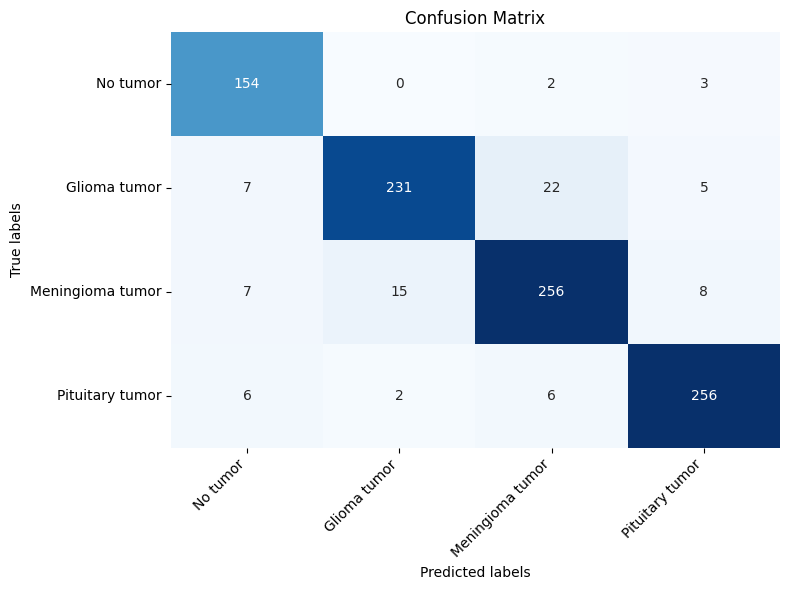

In [ ]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Get the number of classes
num_classes = len(class_map)

# Create a figure and axis
plt.figure(figsize=(8, 6))
ax = plt.gca()

# Create a heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False, ax=ax)

# Set labels, title, and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Set the tick labels using the class_map
class_map_inv = {0 : 'No tumor', 1 : 'Glioma tumor', 2 : 'Meningioma tumor', 3 : 'Pituitary tumor'}
tick_labels = [class_map_inv[label] for label in range(num_classes)]
ax.xaxis.set_ticklabels(tick_labels)
ax.yaxis.set_ticklabels(tick_labels)

# Rotate tick labels if needed
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Show the plot
plt.tight_layout()
plt.show()

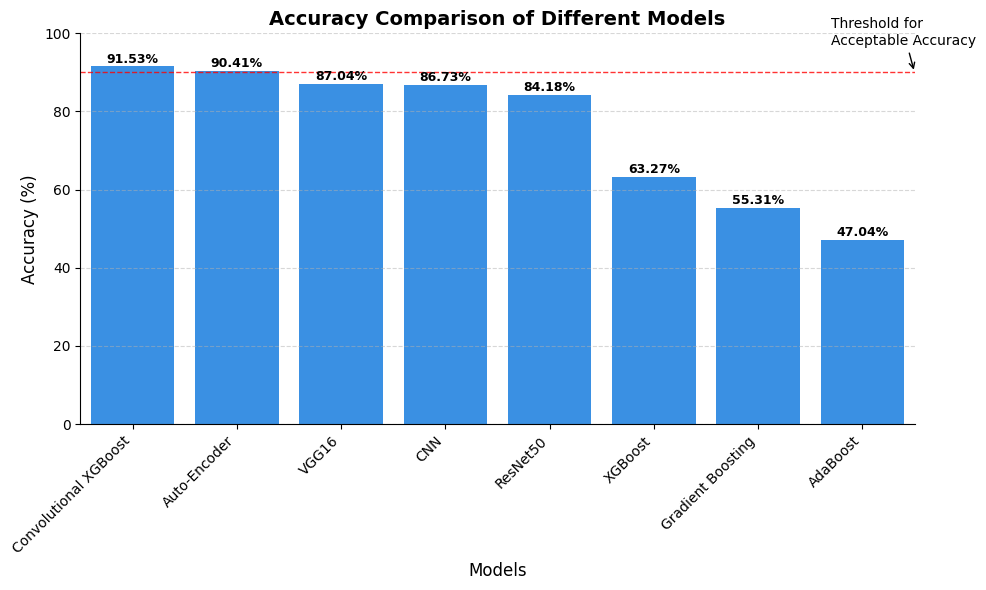

In [ ]:
# Assuming you have the accuracies stored in variables
model_accs = [model1_acc * 100, model2_acc * 100, model3_acc * 100, model4_acc * 100, ada_acc * 100, gb_acc * 100, xgb_acc * 100, xgb_conv_acc * 100]
model_names = ['CNN', 'Auto-Encoder', 'VGG16', 'ResNet50', 'AdaBoost', 'Gradient Boosting', 'XGBoost', 'Convolutional XGBoost']

# Sort the accuracies and model names in descending order
sorted_indices = sorted(range(len(model_accs)), key=lambda k: model_accs[k], reverse=True)
sorted_model_accs = [model_accs[i] for i in sorted_indices]
sorted_model_names = [model_names[i] for i in sorted_indices]

# Set a custom color for the bars
bar_color = 'dodgerblue'

# Create the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_model_names, y=sorted_model_accs, color=bar_color)

# Customize the plot
plt.xlabel('Models', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Accuracy Comparison of Different Models', fontsize=14, fontweight='bold')
plt.ylim([0, 100])
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

# Add the accuracy values with '%' sign on top of each bar
for i, acc in enumerate(sorted_model_accs):
    plt.text(i, acc + 1, f'{acc:.2f}%', ha='center', fontsize=9, fontweight='bold')

# Remove the top and right spines
sns.despine()

# Add gridlines to the plot
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Add a horizontal line at 90% accuracy
plt.axhline(90, color='red', linestyle='--', linewidth=1, alpha=0.8)

# Annotate the line at 90% accuracy
plt.annotate('Threshold for\nAcceptable Accuracy', xy=(len(sorted_model_names)-0.5, 90), xycoords='data',
             xytext=(-60, 20), textcoords='offset points', arrowprops=dict(arrowstyle='->', color='black'))

# Display the plot
plt.tight_layout()
plt.show()